# Adiabatic State Preparation


In [37]:
from rich import print as pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from core.interface.math import *
from core.interface.analog.operator import *
from core.interface.analog.operation import *
from core.backend.metric import *
from core.backend.task import Task, TaskArgsAnalog

from analog_emulator.qutip_backend import QutipBackend

In [38]:
X, Y, Z, I = PauliX(), PauliY(), PauliZ(), PauliI()

In [39]:
Hxx = X @ X
Hz = I @ Z + Z @ I

linear = MathStr(string="0.05*t")

H = -(1 - linear) * Hz + -linear * Hxx

gate = AnalogGate(hamiltonian=H)

Gxx = AnalogGate(hamiltonian=Hxx)

In [40]:
n = 2  # number of qubits

circuit = AnalogCircuit()
circuit.evolve(gate=gate, duration=20)
circuit.evolve(gate=Gxx, duration=10)

In [46]:
args = TaskArgsAnalog(
    n_shots=100,
    metrics={
        "Z": Expectation(operator=0.5 * (I @ Z + Z @ I)),
        "XX": Expectation(operator=X @ X),
    },
    dt=1e-2,
)

task = Task(program=circuit, args=args)

In [50]:
backend = QutipBackend()
expt, args = backend.compile(task=task)
print(args)
results = backend.run(task=task)

layer='analog' n_shots=100 fock_cutoff=4 dt=0.01 metrics={'Z': QutipExpectation(operator=[(Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]], MathNum(class_='MathNum', value=0.5)), (Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]], MathNum(class_='MathNum', value=0.5))]), 'XX': QutipExpectation(operator=[(Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]], MathNum(class_='MathNum', value=1))])}


In [48]:
pprint(results.model_fields.keys())
print(results.counts)

dict_keys(['class_', 'layer', 'times', 'state', 'metrics', 'counts', 'runtime'])

{}


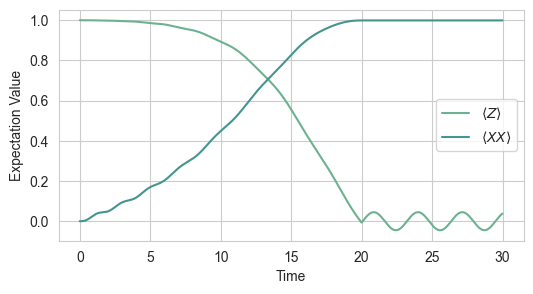

In [49]:
fig, ax = plt.subplots(1, 1, figsize=[6, 3])
colors = sns.color_palette(palette="crest", n_colors=4)

for k, (name, metric) in enumerate(results.metrics.items()):
    ax.plot(results.times, metric, label=f"$\\langle {name} \\rangle$", color=colors[k])
ax.set(xlabel="Time", ylabel="Expectation Value")
ax.legend();

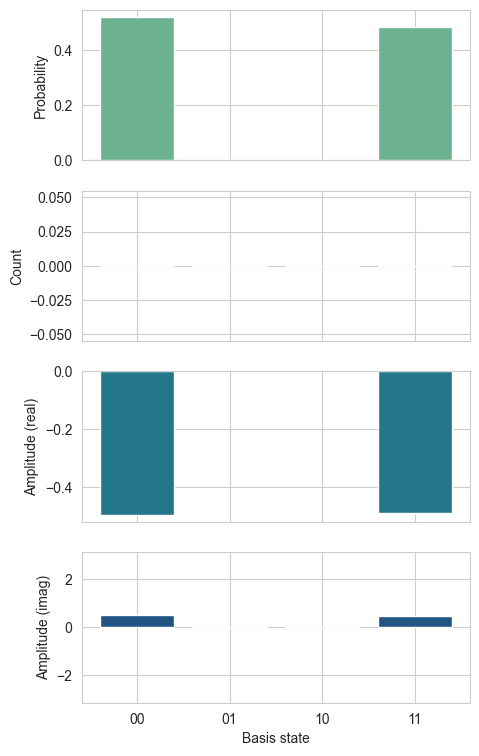

In [19]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=[5, 9])

state = np.array([basis.real + 1j * basis.imag for basis in results.state])
bases = ["".join(bits) for bits in itertools.product("01", repeat=n)]
counts = {basis: results.counts.get(basis, 0) for basis in bases}

ax = axs[0]
ax.bar(x=bases, height=np.abs(state) ** 2, color=colors[0])
ax.set(ylabel="Probability")


ax = axs[1]
ax.bar(x=bases, height=list(counts.values()), color=colors[1])
ax.set(ylabel="Count")


ax = axs[2]
ax.bar(x=bases, height=state.real, color=colors[2])
ax.set(ylabel="Amplitude (real)")

ax = axs[3]
ax.bar(x=bases, height=state.imag, color=colors[3])
ax.set(xlabel="Basis state", ylabel="Amplitude (imag)", ylim=[-np.pi, np.pi]);